In [1]:
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot
import pandas as pd
import plotting as my_plot
import os

import auxil_ML as aux
import dio3 as dio

In [94]:
#folder = '../ML_3FGL_paper_extra/data/python files/catas/'
folder = '../SOM/'
plot_folder = '../ML_3FGL_paper/plots/oversample'
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

cat = '4FGL'
pop = 'OTHER' #'PSR', 'AGN'
nclass = 3
#pop = 'PSR'
quantity = 'Flux1000'
save_plots = 1

my_plot.setup_figure_pars()


alg0 = 'LR'
algs0 = ['RF', 'BDT', 'LR', 'NN']
algs_O = [alg + '_O' for alg in algs0]
algs_S = [alg + '_S' for alg in algs0]

algs = algs0 + algs_O + algs_S

bins = np.linspace(-10.5, -6.5, 17)
binsc = (bins[1:] + bins[:-1])/2


In [95]:

#cat = '4FGL' # '3FGL', '4FGL'
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    #fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
    fn_cat = '../PS_comparison/gll_psc_v27.fit' # 4FGL_DR2


if cat == '4FGL':
    #cat_name = '4FGL'
    cat_name = '4FGL-DR2'
else:
    cat_name = cat
    
#fn_pcat = '%s/%s_catalog_newfeats.csv' % (folder, cat)
#fn_pcat = '%s/%s_%iClass_Catalog_AllSamplings.csv' % (folder, cat_name, nclass)
fn_pcat = '%s/%s_prob_catalog_%iclasses.csv' % (folder, cat_name, nclass)
fn_pcat_smote = '%s/%s_prob_catalog_%iclasses_SMOTE.csv' % (folder, cat_name, nclass)



hdu_cat = fits.open(fn_cat)
pcat_fgl = pd.read_csv(fn_pcat, index_col='Source_Name_%s' % cat)
pcat_fgl_smote = pd.read_csv(fn_pcat_smote, index_col='Source_Name_%s' % cat)
scols = [clm for clm in pcat_fgl_smote.columns if clm.endswith('_S')]
pcat_fgl = pcat_fgl.merge(pcat_fgl_smote[scols], left_index=True, right_index=True)

index = np.array(hdu_cat[1].data.field('Source_Name'), dtype=str)
data = {quantity:np.array(hdu_cat[1].data.field(quantity), dtype=float)}
df_fgl = pd.DataFrame(data=data, index=index)
df_fgl.index = [st.strip() for st in df_fgl.index]
df_fgl = df_fgl.loc[pcat_fgl.index]
if quantity == 'Flux1000':
    df_fgl = np.log10(df_fgl)

In [96]:
#print(list(pcat_fgl.columns))

In [97]:
#pcat_fgl.columns
fn_pcat

'../SOM//4FGL-DR2_prob_catalog_3classes.csv'

In [98]:
class_sources = (pcat_fgl['Category_%s' %cat] == pop)
unassoc_sources = (pcat_fgl['Category_%s' %cat] == 'UNAS')

unassoc_values_fgl = df_fgl[quantity].loc[unassoc_sources]
assoc_values_fgl = df_fgl[quantity].loc[~unassoc_sources]
class_values_fgl = df_fgl[quantity].loc[class_sources]


In [99]:
if 0:
    for alg in algs_S:
        print(alg)
        label = '%s_%s' % (pop, alg)
        print(pcat_fgl.loc[unassoc_sources, label])

In [100]:
prob_fgl_unassoc = {}
prob_fgl_class = {}
unas_dNdS = {}
class_dNdS = {}
for alg in algs:
    label = '%s_%s' % (pop, alg)
    vals = np.array(pcat_fgl.loc[unassoc_sources, label])
    if pcat_fgl.loc[unassoc_sources, label].hasnans:
        nan_mask = np.isnan(pcat_fgl.loc[unassoc_sources, label])
        vals[nan_mask] = 0.
        print(alg, 'number of nans:')
        print(sum(nan_mask))
        print(pcat_fgl.loc[unassoc_sources, label][nan_mask])
    prob_fgl_unassoc[alg] = vals # prob
    prob_fgl_class[alg] = np.array(pcat_fgl.loc[~unassoc_sources, label]) # prob
    unas_dNdS[alg] = aux.h2cum(np.histogram(unassoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_unassoc[alg])[0])
    class_dNdS[alg] = aux.h2cum(np.histogram(assoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_class[alg])[0])

assoc_class_counts = aux.h2cum(np.histogram(class_values_fgl, bins=bins)[0])

Save figure to file: ../ML_3FGL_paper/plots/oversample/N_logS_4FGL-DR2_OTHER_3classes_O_vs_S.pdf


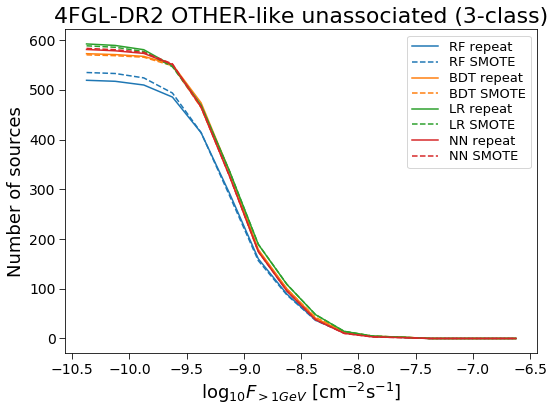

In [101]:
plot = pyplot.plot

add_2class = True

pyplot.figure()
for alg in algs0:
    ln = plot(binsc, unas_dNdS[alg + '_O'], label='%s repeat' % alg)
    color = ln[0].get_color()
    plot(binsc, unas_dNdS[alg + '_S'], c=color, ls='--', label='%s SMOTE' % alg)
    #print(alg)
    #print(unas_dNdS[alg + '_O'])
    #print(unas_dNdS[alg + '_S'])
    
pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
pyplot.ylabel('Number of sources')
pyplot.legend(fontsize=13, labelspacing=0.2)

title = '%s %s-like unassociated (%i-class)' % (cat_name, pop, nclass)
pyplot.title(title);


if save_plots:
    figfn = '%s/N_logS_%s_%s_%iclasses_O_vs_S.pdf' % (plot_folder, cat_name, pop, nclass)
    print('Save figure to file:', figfn)
    pyplot.savefig(figfn)
